---
title: ARIMA and SARIMA models
---

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA

Today we shall first look at the theoretical ACF and PACF functions of ARMA processes. The key observation is this: (a) For MA($q$), the ACF becomes zero for $h > q$. (b) For AR($p$), the PACF becomes zero for $h > p$. (c) For ARMA(p, q) with both $p, q \geq 1$, neither the ACF nor the PACF becomes zero after a finite lag. In this case, determining $p$ and $q$ by looking at the ACF and PACF alone is difficult. 

## ACF and PACF of ARMA processes


Different ARMA processes are obtained by changing the ma_coeffs and ar_coeffs in the code below. We are using the statsmodels functions arma_acf and arma_pacf below to compute the ACF and PACF. 

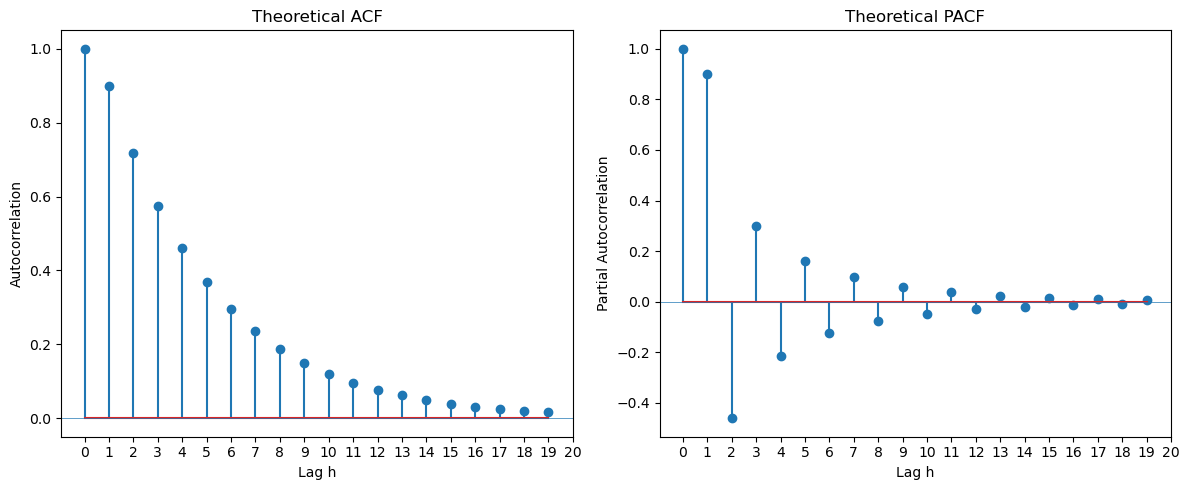

In [2]:
#MA(1)
th = 0.8
ma_coeffs = [1]
#ma_coeffs = [1, 0, 0, 0, th]
ma_coeffs = [1, th]
ph = 0.8
ar_coeffs = [1]
ar_coeffs = [1, -ph]
#ar_coeffs = [1, 0, 0, 0, -ph]
#th2 = 0.8
#ma_coeffs = [1, th, th2]
L = 20
corrs = arma_acf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
par_corrs = arma_pacf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.stem(range(L), corrs)
ax1.set(title = 'Theoretical ACF', xlabel = 'Lag h', ylabel = 'Autocorrelation')
ax1.axhline(0, lw = 0.5)
ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 

ax2.stem(range(L), par_corrs)
ax2.set(title = 'Theoretical PACF', xlabel = 'Lag h', ylabel = 'Partial Autocorrelation')
ax2.axhline(0, lw = 0.5)
ax2.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 
plt.tight_layout()
plt.show()

Below, we simulate data from the ARMA process with coefficients given below, and then look at the sample ACF and PACF. These are sample versions of the above theoretical ACF and PACF. They look similar but are much more noisy. 

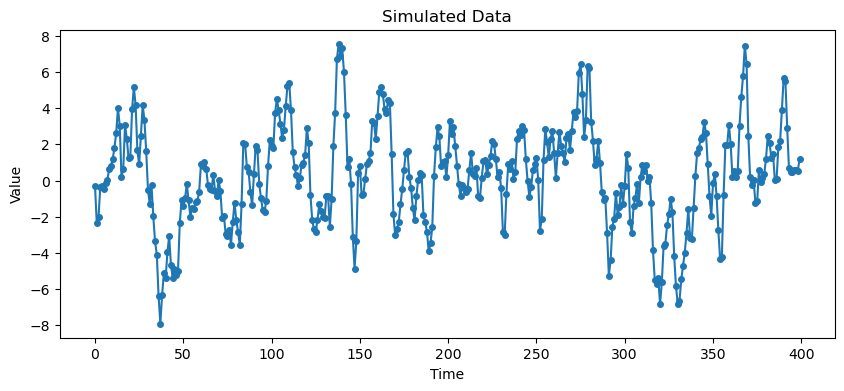

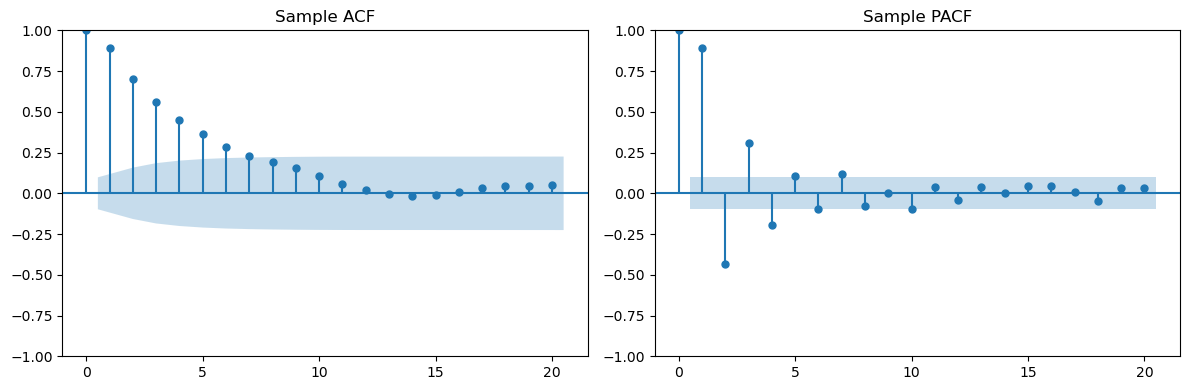

In [3]:
# Simulate data
arma_process = ArmaProcess(ar_coeffs, ma_coeffs)
dt = arma_process.generate_sample(nsample=400)

# Plot simulated series
plt.figure(figsize=(10, 4))
plt.plot(dt, 'o-', markersize=4)
plt.title("Simulated Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# Plot sample ACF/PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(dt, lags=L, ax=ax1, title='Sample ACF')
plot_pacf(dt, lags=L, ax=ax2, title='Sample PACF')
plt.tight_layout()
plt.show()

## co2 dataset (Motivation for Multiplicative Seasonal ARMA models)

Next we study seasonal and multiplicative seasonal ARMA models. The following dataset provides some motivation for considering these models.

     Unnamed: 0       x
0             1  363.05
1             2  364.18
2             3  364.87
3             4  364.47
4             5  364.32
..          ...     ...
127         128  368.69
128         129  368.55
129         130  373.39
130         131  378.49
131         132  381.62

[132 rows x 2 columns]


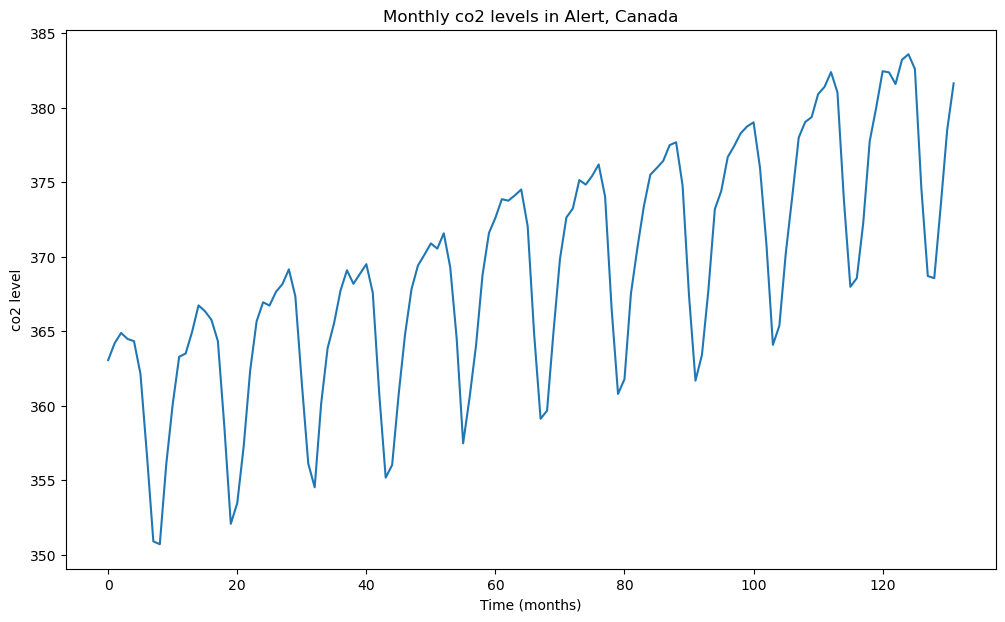

In [4]:
co2 = pd.read_csv('co2_TSA.csv')
print(co2)
#This is a simple time series dataset from the R package TSA 
#TSA is an R package that is written by the authors of the book "Time Series Analysis with Applications in R (second edition)"
#by Jonathan Cryer and Kung-Sik Chan
#This dataset gives the monthly co2 levels in Alert, Canada from January 1994 to December 2004 (132 observations in total for 11 years)
y = co2['x']
plt.figure(figsize = (12, 7))
plt.plot(y)
plt.xlabel('Time (months)')
plt.ylabel('co2 level')
plt.title('Monthly co2 levels in Alert, Canada')
plt.show()

Before fitting stationary ARMA models, we first preprocess the data by differencing. We first take the seasonal difference: $\nabla_s y_t = y_t - y_{t-s}$ where $s = 12$. 

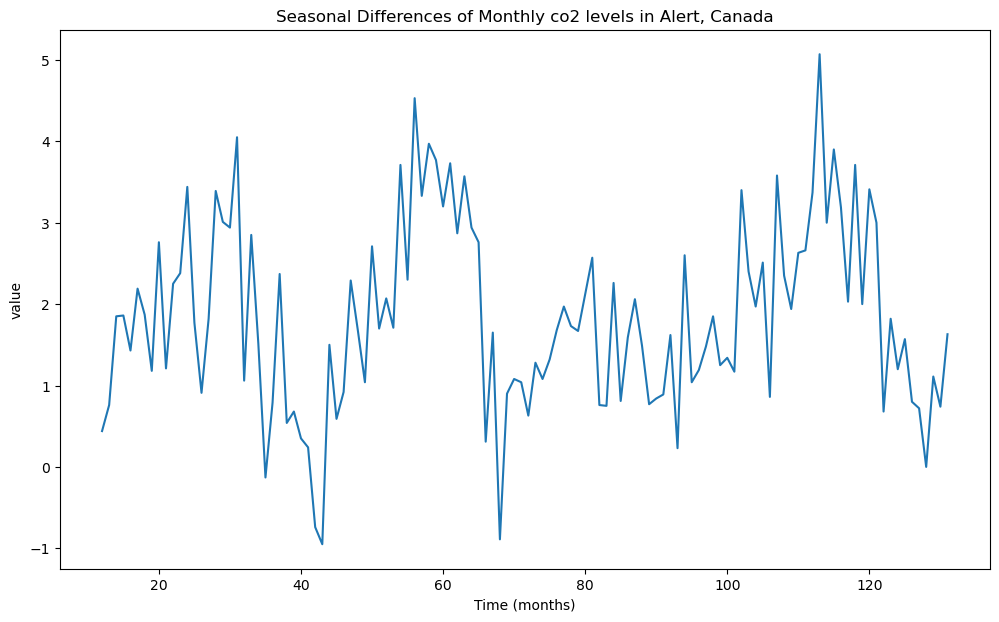

In [6]:
#Seasonal differencing: y_t - y_{t-12}
ydiff12 = y.diff(periods = 12) #this works when y is a pandas series (it will not work when y is a np array for example)
plt.figure(figsize = (12, 7))
plt.plot(ydiff12)
plt.xlabel('Time (months)')
plt.ylabel('value')
plt.title('Seasonal Differences of Monthly co2 levels in Alert, Canada')
plt.show()


Note that there will be NAs corresponding to the first 12 observations. The presence of these NAs might cause issues with subsequent functions (such as plot_acf and plot_pacf). 

In [7]:
#there will be NAs in the first twelve entries of ydiff12
print(ydiff12)

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
127    0.72
128    0.00
129    1.11
130    0.74
131    1.63
Name: x, Length: 132, dtype: float64


Below we use '.dropna()' to remove NAs before plotting ACF and PACF. 

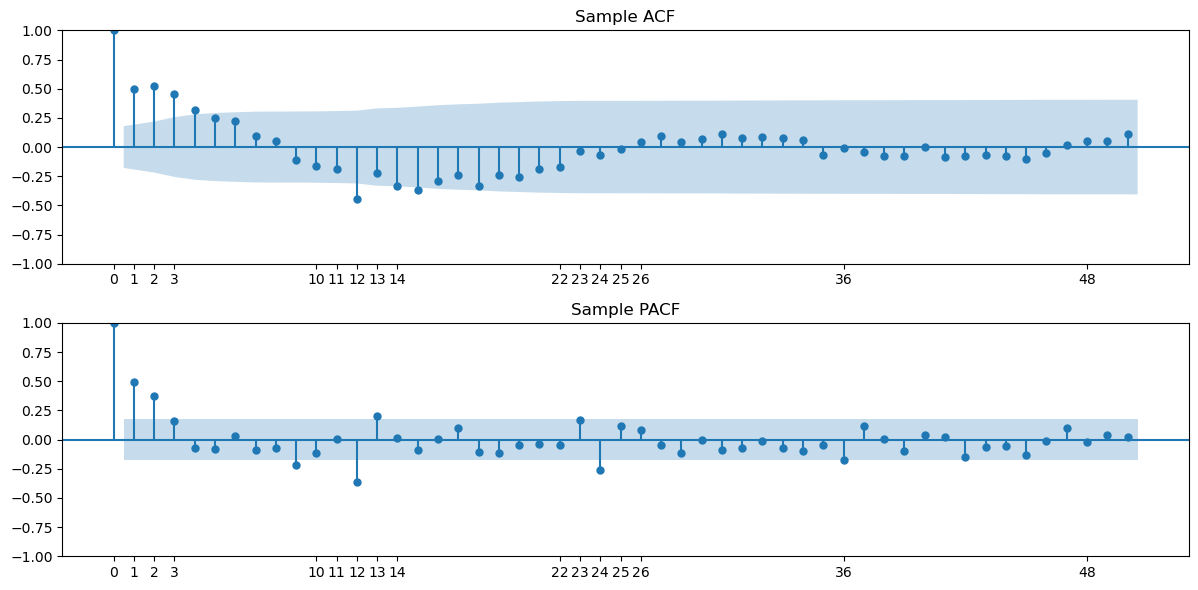

In [8]:
h_max = 50
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))
plot_acf(ydiff12.dropna(), lags = h_max, ax = axes[0])
axes[0].set_title("Sample ACF")
axes[0].set_xticks([0, 1, 2, 3, 10, 11, 12, 13, 14, 22, 23, 24, 25, 26, 36, 48]) 
plot_pacf(ydiff12.dropna(), lags = h_max, ax = axes[1])
axes[1].set_title("Sample PACF")
axes[1].set_xticks([0, 1, 2, 3, 10, 11, 12, 13, 14, 22, 23, 24, 25, 26, 36, 48]) 
plt.tight_layout()
plt.show()

Based on the plot of $\nabla_s y_t$, it appear that there are still some trends in the dataset. So we difference one more time before fitting stationary models. 

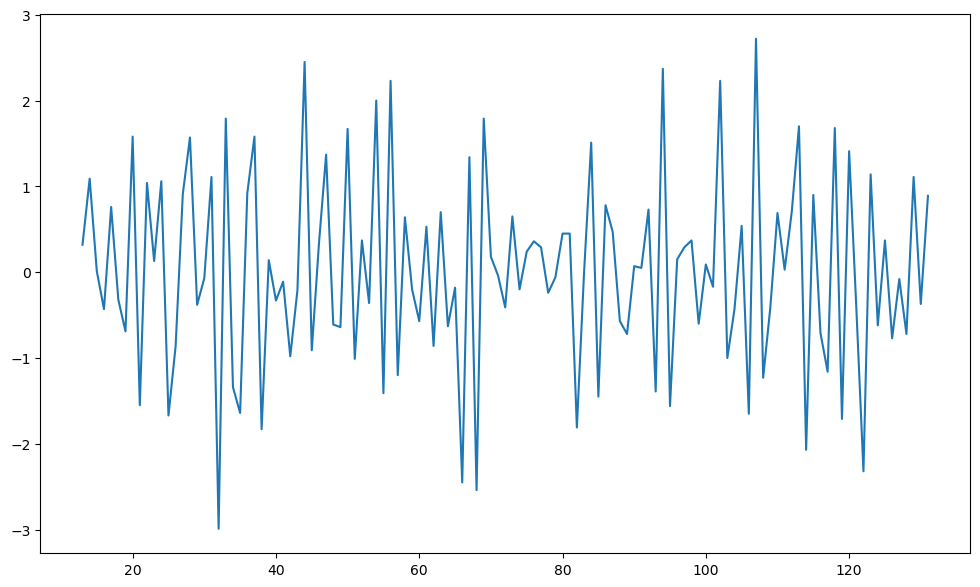

In [9]:
#We now take one more differencing; this time regular differencing
y2d = ydiff12.diff()
plt.figure(figsize = (12, 7))
plt.plot(y2d)
plt.show()

The sample ACF and PACF of this data is plotted using the code below. 

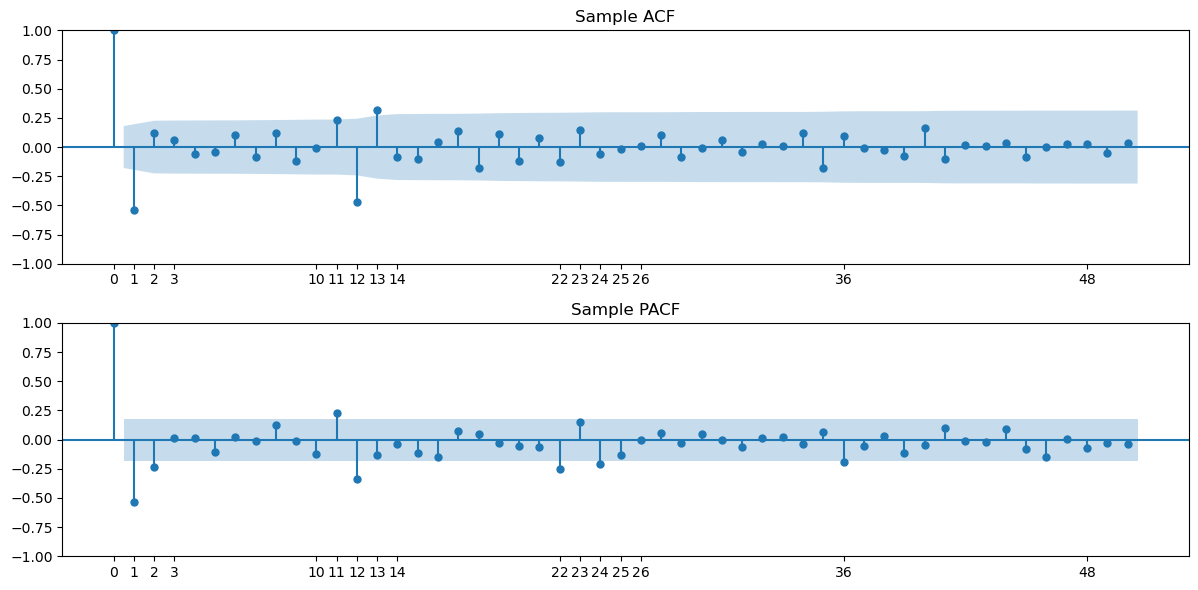

In [10]:
h_max = 50
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))
plot_acf(y2d.dropna(), lags = h_max, ax = axes[0])
axes[0].set_title("Sample ACF")
axes[0].set_xticks([0, 1, 2, 3, 10, 11, 12, 13, 14, 22, 23, 24, 25, 26, 36, 48]) 
plot_pacf(y2d.dropna(), lags = h_max, ax = axes[1])
axes[1].set_title("Sample PACF")
axes[1].set_xticks([0, 1, 2, 3, 10, 11, 12, 13, 14, 22, 23, 24, 25, 26, 36, 48]) 
plt.tight_layout()
plt.show()

The ACF has a large negative autocorrelation at lag one, and then a bunch of small autocorrelations followed by nonnegligible ones at lags 11, 12, 13. If we want to use an MA(q) model here, then $q = 13$ would be reasonable. But that model will have quite a few parameters. It would be preferable to have a simpler MA model with fewer parameters that has an ACF similar to the above sample ACF. To get such a model, we need to learn about seasonal and multiplicative seasonal ARMA models. 

## Seasonal ARMA models

Seasonal ARMA models are given by $\phi(B^s) (y_t - \mu) = \theta(B^s) \epsilon_t$. These are special cases of regular ARMA models with lots of zeros in the AR and MA coefficients. For example, the seasonal MA(1) model with period $s = 4$ is $y_t = \mu + \epsilon_t + \theta \epsilon_{t-4}$ which is also a regular MA(4) model with coefficients $\theta_1 = \theta_2 = \theta_3 = 0$ and $\theta_4 = \theta$. The following code is the same as that used previously to compute the ACF and PACF of ARMA processes. By inputting a bunch of zeros in ma_coeffs and ar_coeffs, we can obtain the ACF and PACF of seasonal ARMA models.

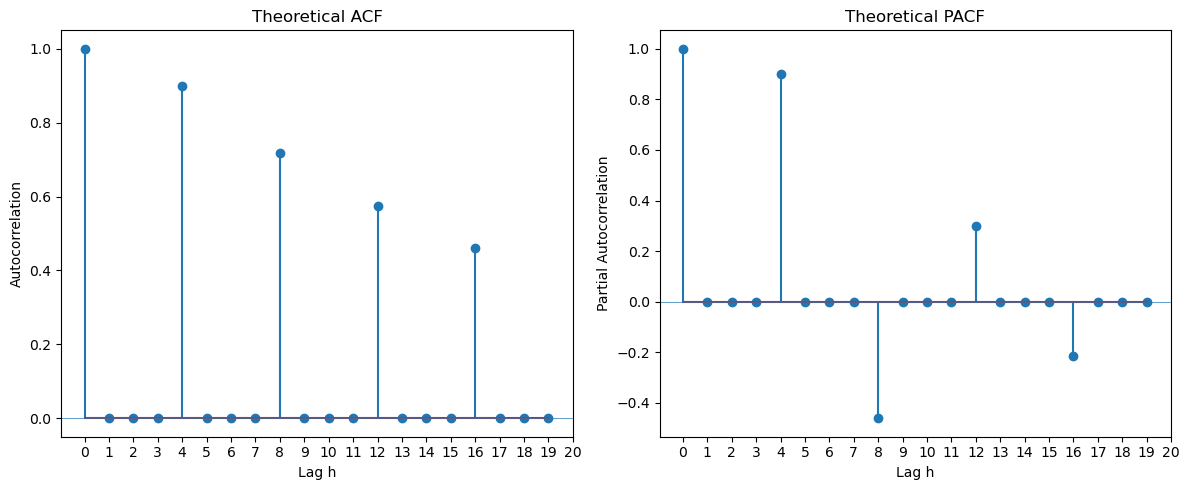

In [11]:
#AR(1)
th = 0.8
ma_coeffs = [1, 0, 0, 0, th] #this corresponds to seasonal MA with period = 4
#ma_coeffs = [1]
#ma_coeffs = [1, th]
ph = 0.8
#ar_coeffs = [1]
#ar_coeffs = [1, -ph]
ar_coeffs = [1, 0, 0, 0, -ph] #this corresponds to seasonal AR with period = 4
#th2 = 0.8
#ma_coeffs = [1, th, th2]
L = 20
corrs = arma_acf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
par_corrs = arma_pacf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.stem(range(L), corrs)
ax1.set(title = 'Theoretical ACF', xlabel = 'Lag h', ylabel = 'Autocorrelation')
ax1.axhline(0, lw = 0.5)
ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 

ax2.stem(range(L), par_corrs)
ax2.set(title = 'Theoretical PACF', xlabel = 'Lag h', ylabel = 'Partial Autocorrelation')
ax2.axhline(0, lw = 0.5)
ax2.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 
plt.tight_layout()
plt.show()

The ACF and PACF of a seasonal ARMA model is non-zero only at the seasonal lags $h = 0, s, 2s, 3s, 4s, \dots$. At these seasonal lags, the ACF and PACF exactly equal those of the non-seasonal ARMA. 

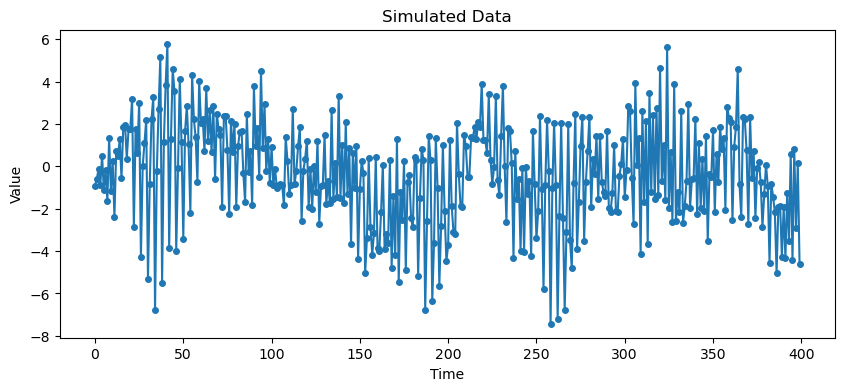

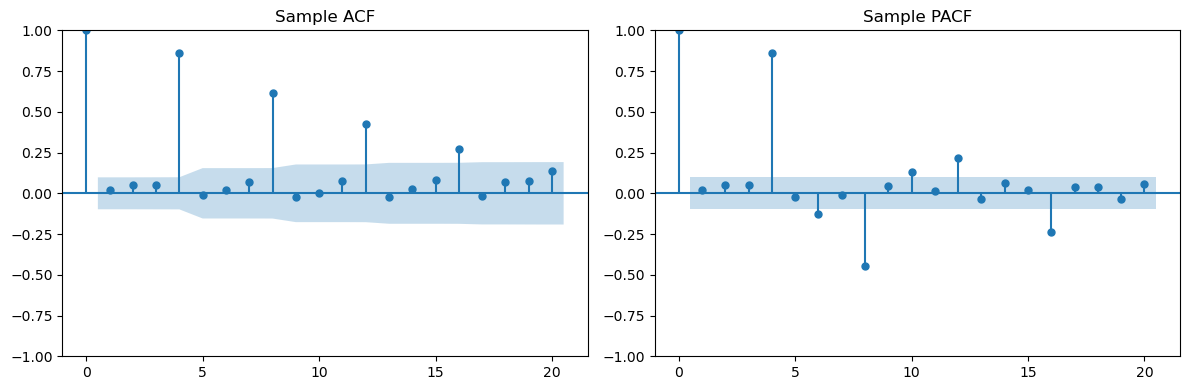

In [12]:
# Simulate data
arma_process = ArmaProcess(ar_coeffs, ma_coeffs)
dt = arma_process.generate_sample(nsample=400)

# Plot simulated series
plt.figure(figsize=(10, 4))
plt.plot(dt, 'o-', markersize=4)
plt.title("Simulated Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# Plot sample ACF/PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(dt, lags=L, ax=ax1, title='Sample ACF')
plot_pacf(dt, lags=L, ax=ax2, title='Sample PACF')
plt.tight_layout()
plt.show()

## Multiplicative Seasonal ARMA models

Next we look at the ACF and PACF of Multiplicative Seasonal ARMA models. These have aspects of both the usual ARMA models as well as the Seasonal ARMA models. It is a challenge to look at the ACF and PACF functions and guess the form of the model based on those plots. One can try the following heuristic strategy. First look at the ACF and PACF only at the seasonal lags $h = 0, s, 2s, 3s, \dots$. From here, try to guess the order of the seasonal part of the ARMA model. For example, if ACF(hs) seems to be negligible for $h > Q$, then the seasonal part could be MA(Q). If PACF(hs) seems negligible for $h > P$, then seasonal part could be AR(P). Next look at only the initial few non-seasonal lags ($h = 0, 1, 2, 3, \dots, s-1$). From here, attempt to guess the orders of the regular part of the model. 

First example is $ARMA(0, 0, 1) X (0, 0, 1)_{12}$ (which can be also written as $MA(1) \times MA(1)_{12}$). 

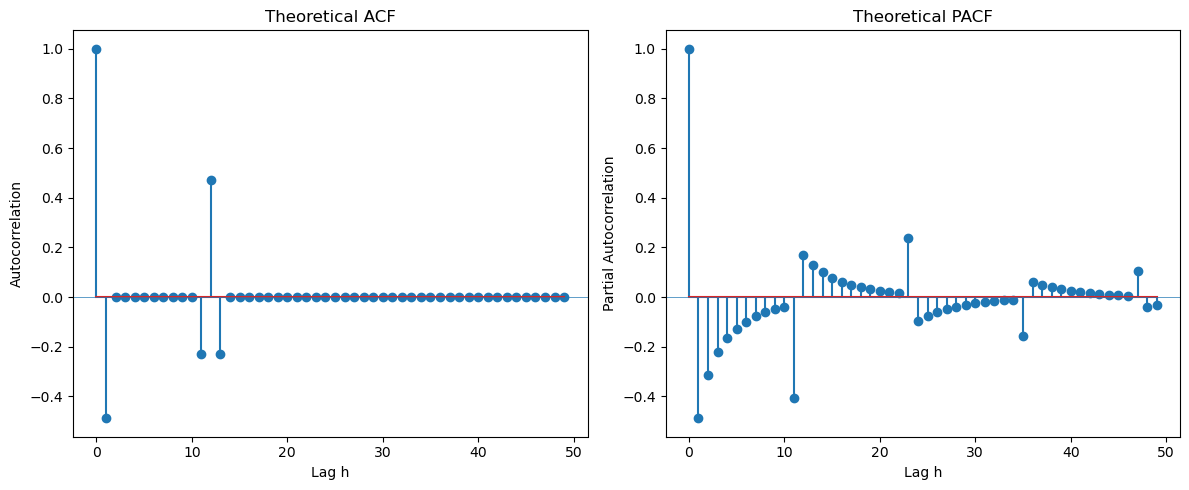

In [193]:
th = -0.8
Th = 0.7
ma_coeffs = np.zeros(14)
ma_coeffs[0] = 1
ma_coeffs[1] = th
ma_coeffs[12] = Th
ma_coeffs[13] = th*Th
#ma_coeffs = [1, 0, 0, 0, th]
#ma_coeffs = [1]
#ma_coeffs = [1, th]
#ph = 0.8
ar_coeffs = [1]
#ar_coeffs = [1, -ph]
#ar_coeffs = [1, 0, 0, 0, -ph]
#th2 = 0.8
#ma_coeffs = [1, th, th2]
L = 50
corrs = arma_acf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
par_corrs = arma_pacf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.stem(range(L), corrs)
ax1.set(title = 'Theoretical ACF', xlabel = 'Lag h', ylabel = 'Autocorrelation')
ax1.axhline(0, lw = 0.5)
#ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 

ax2.stem(range(L), par_corrs)
ax2.set(title = 'Theoretical PACF', xlabel = 'Lag h', ylabel = 'Partial Autocorrelation')
ax2.axhline(0, lw = 0.5)
#ax2.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 
plt.tight_layout()
plt.show()

From the ACF at seasonal lags, it is clear that the seasonal part is $MA(1)_{12}$. From the ACF at the initial few lags, it is clear that the regular part is also $MA(1)$, leading to the overall model $MA(1) \times MA(1)_{12}$.  

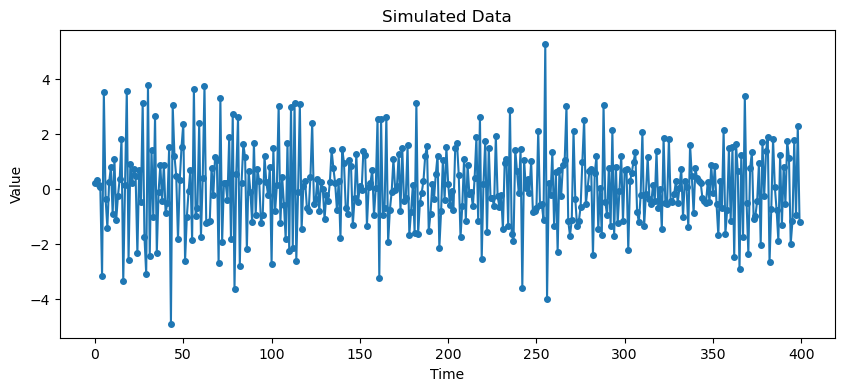

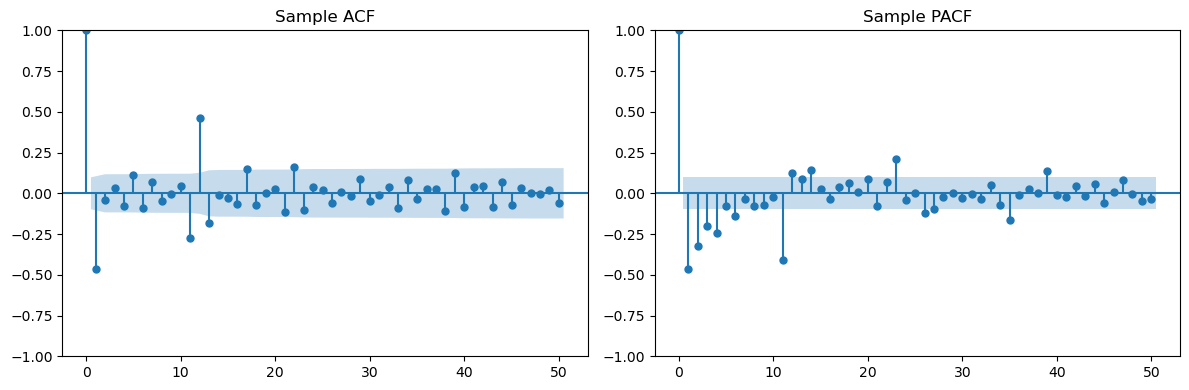

In [195]:
# Simulate data
arma_process = ArmaProcess(ar_coeffs, ma_coeffs)
dt = arma_process.generate_sample(nsample=400)

# Plot simulated series
plt.figure(figsize=(10, 4))
plt.plot(dt, 'o-', markersize=4)
plt.title("Simulated Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# Plot sample ACF/PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(dt, lags=L, ax=ax1, title='Sample ACF')
plot_pacf(dt, lags=L, ax=ax2, title='Sample PACF')
plt.tight_layout()
plt.show()

Second Example is $ARMA(0, 1) \times (1, 0)_{12}$ (which can also be written as $MA(1)) \times AR(1)_{12}$). 

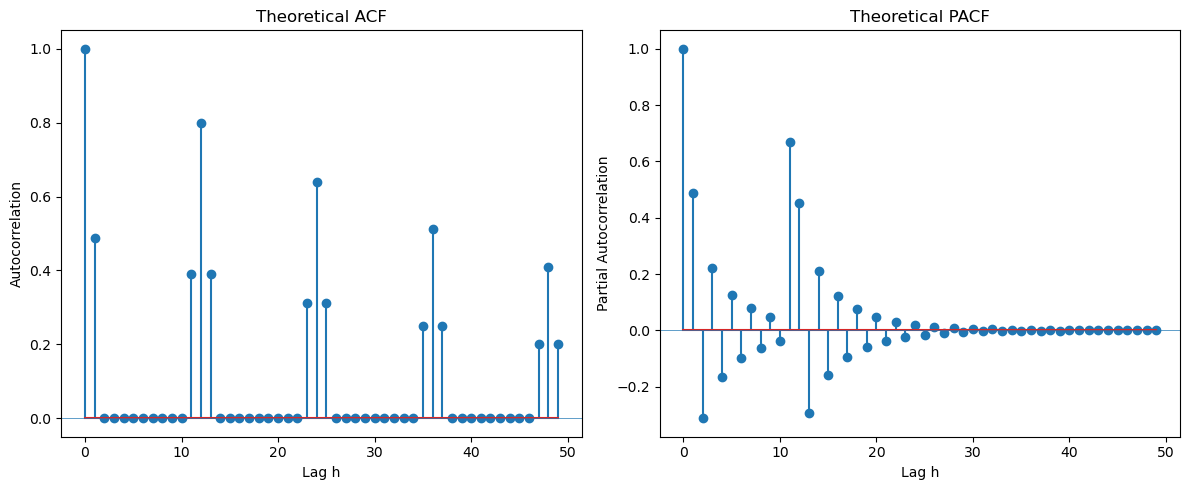

In [196]:
th = 0.8
ma_coeffs = np.array([1, th])
ph = 0.8
ar_coeffs = np.zeros(13)
ar_coeffs[0] = 1
ar_coeffs[12] = -ph
#ar_coeffs = [1, -ph]
#ar_coeffs = [1, 0, 0, 0, -ph]
#th2 = 0.8
#ma_coeffs = [1, th, th2]
L = 50
corrs = arma_acf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
par_corrs = arma_pacf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.stem(range(L), corrs)
ax1.set(title = 'Theoretical ACF', xlabel = 'Lag h', ylabel = 'Autocorrelation')
ax1.axhline(0, lw = 0.5)
#ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 

ax2.stem(range(L), par_corrs)
ax2.set(title = 'Theoretical PACF', xlabel = 'Lag h', ylabel = 'Partial Autocorrelation')
ax2.axhline(0, lw = 0.5)
#ax2.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 
plt.tight_layout()
plt.show()

From the PACF at the seasonal lags (12, 24, ...), there is only one spike (at lag 12) which suggests that the seasonal part is AR(1). Looking at the initial few lags (1, 2, 3, ...), the ACF reveals an MA(1) structure. The overall model can be guessed as $MA(1) \times AR(1)_{12}$. 

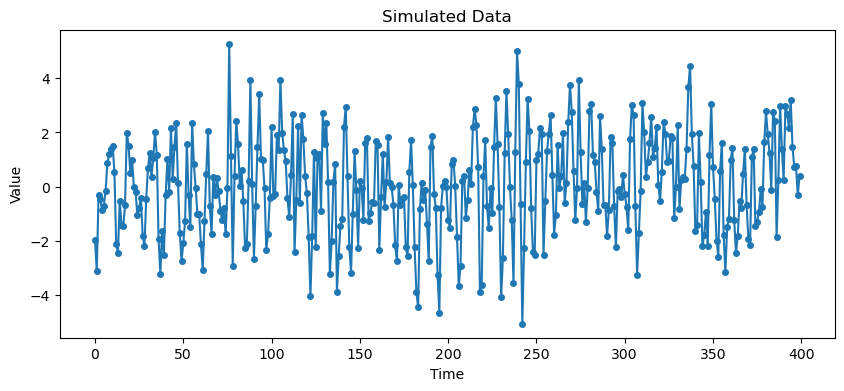

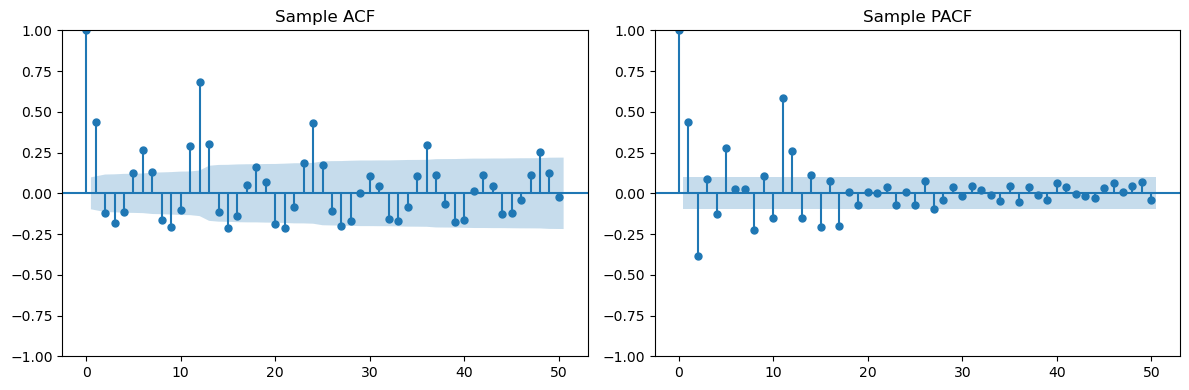

In [197]:
# Simulate data
arma_process = ArmaProcess(ar_coeffs, ma_coeffs)
dt = arma_process.generate_sample(nsample=400)

# Plot simulated series
plt.figure(figsize=(10, 4))
plt.plot(dt, 'o-', markersize=4)
plt.title("Simulated Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# Plot sample ACF/PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(dt, lags=L, ax=ax1, title='Sample ACF')
plot_pacf(dt, lags=L, ax=ax2, title='Sample PACF')
plt.tight_layout()
plt.show()

Example Three is $MA(2) \times AR(1)_{12}$. 

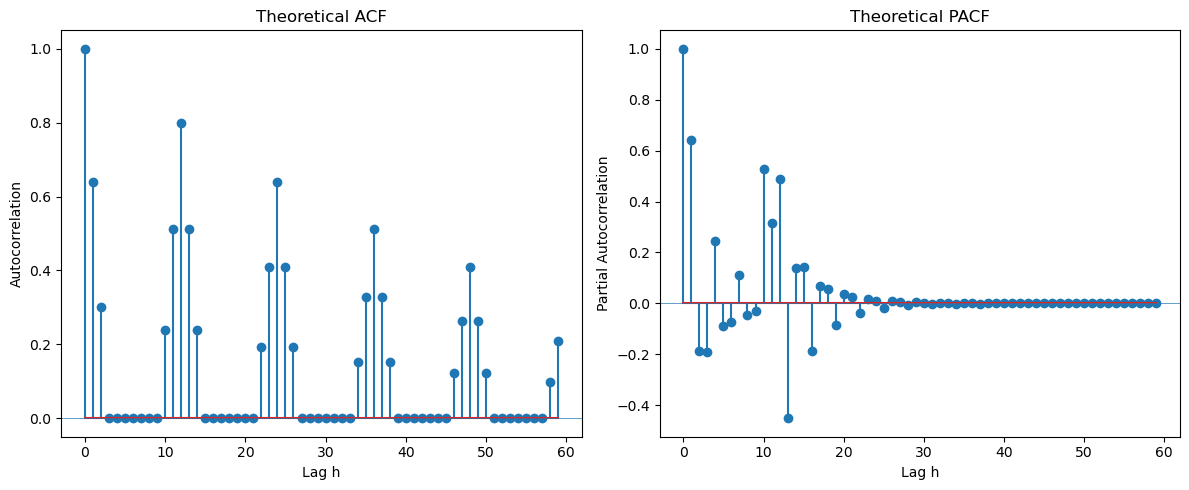

In [198]:
th1 = 0.8
th2 = 0.6
ma_coeffs = np.array([1, th1, th2])
ph = 0.8
ar_coeffs = np.zeros(13)
ar_coeffs[0] = 1
ar_coeffs[12] = -ph
#ar_coeffs = [1, -ph]
#ar_coeffs = [1, 0, 0, 0, -ph]
#th2 = 0.8
#ma_coeffs = [1, th, th2]
L = 60
corrs = arma_acf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
par_corrs = arma_pacf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.stem(range(L), corrs)
ax1.set(title = 'Theoretical ACF', xlabel = 'Lag h', ylabel = 'Autocorrelation')
ax1.axhline(0, lw = 0.5)
#ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 

ax2.stem(range(L), par_corrs)
ax2.set(title = 'Theoretical PACF', xlabel = 'Lag h', ylabel = 'Partial Autocorrelation')
ax2.axhline(0, lw = 0.5)
#ax2.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 
plt.tight_layout()
plt.show()

Looking at the seasonal lags (12, 24, 36, ...) in the PACF, we can clearly see only one spike suggesting $AR(1)_{12}$. Looking at lags 1, 2, 3, ... in the ACF, we see two spikes suggesting $MA(2)$. The overall model can be guessed as $MA(2) \times AR(1)_{12}$. 

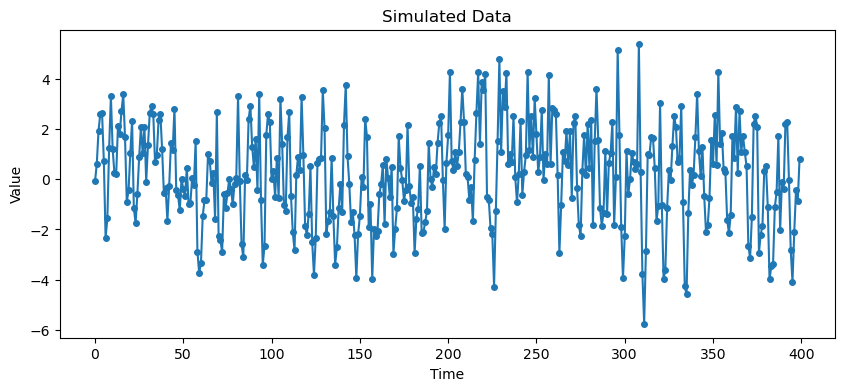

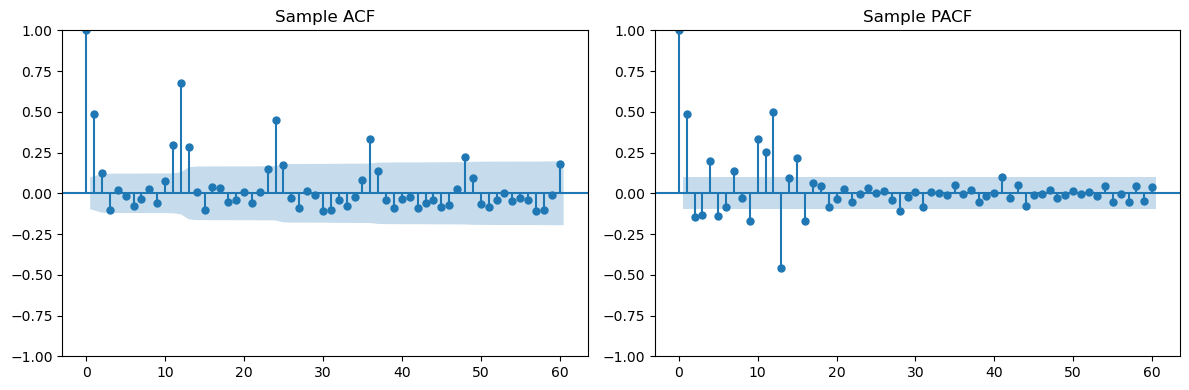

In [199]:
# Simulate data
arma_process = ArmaProcess(ar_coeffs, ma_coeffs)
dt = arma_process.generate_sample(nsample=400)

# Plot simulated series
plt.figure(figsize=(10, 4))
plt.plot(dt, 'o-', markersize=4)
plt.title("Simulated Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# Plot sample ACF/PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(dt, lags=L, ax=ax1, title='Sample ACF')
plot_pacf(dt, lags=L, ax=ax2, title='Sample PACF')
plt.tight_layout()
plt.show()

Example Four is $AR(1) \times AR(1)_{12}$. 

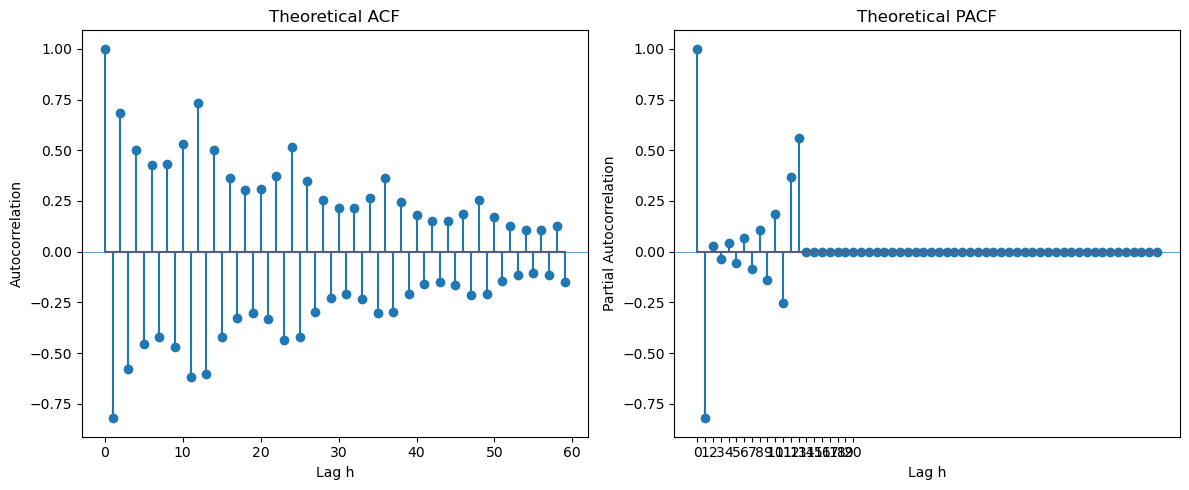

In [14]:
ph = -0.8
Ph = 0.7
ar_coeffs = np.zeros(14)
ar_coeffs[0] = 1
ar_coeffs[1] = -ph
ar_coeffs[12] = -Ph
ar_coeffs[13] = ph*Ph
ma_coeffs = [1]
L = 60
corrs = arma_acf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
par_corrs = arma_pacf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.stem(range(L), corrs)
ax1.set(title = 'Theoretical ACF', xlabel = 'Lag h', ylabel = 'Autocorrelation')
ax1.axhline(0, lw = 0.5)
#ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 

ax2.stem(range(L), par_corrs)
ax2.set(title = 'Theoretical PACF', xlabel = 'Lag h', ylabel = 'Partial Autocorrelation')
ax2.axhline(0, lw = 0.5)
ax2.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 
plt.tight_layout()
plt.show()

At the seasonal lags 12, 24, 36, ..., the PACF has one spike suggesting $AR(1)_{12}$. At lags 1, 2, 3, ..., there is also one spike in the PACF suggesting $AR(1)$. The overall model is therefore guessed as $AR(1) \times AR(1)_{12}$. 

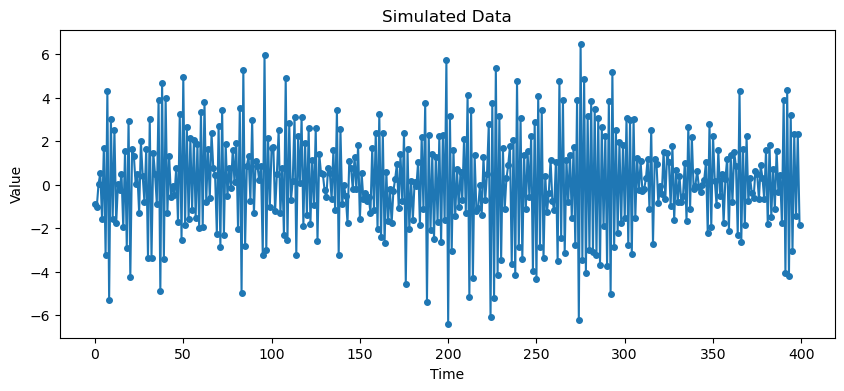

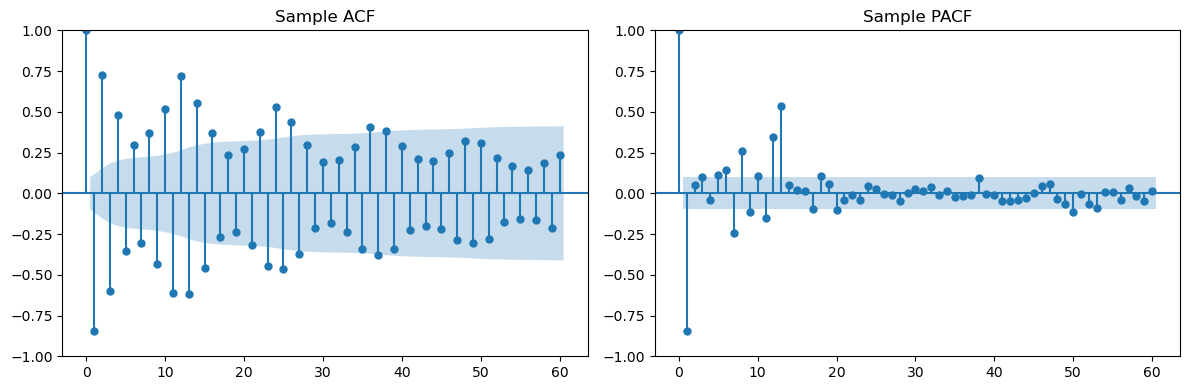

In [15]:
# Simulate data
arma_process = ArmaProcess(ar_coeffs, ma_coeffs)
dt = arma_process.generate_sample(nsample=400)

# Plot simulated series
plt.figure(figsize=(10, 4))
plt.plot(dt, 'o-', markersize=4)
plt.title("Simulated Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# Plot sample ACF/PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(dt, lags=L, ax=ax1, title='Sample ACF')
plot_pacf(dt, lags=L, ax=ax2, title='Sample PACF')
plt.tight_layout()
plt.show()

In all the examples, it is much harder (due to noise) to guess the models from the sample ACF and PACFs (from data generated according to the model) compared to the  theoretical ACF and PACF of the model. 

## Back to co2 dataset

Let us now get back to the co2 dataset and fit a suitable SARIMA model. 

In [16]:
co2 = pd.read_csv('co2_TSA.csv')
print(co2)
y = co2['x']

     Unnamed: 0       x
0             1  363.05
1             2  364.18
2             3  364.87
3             4  364.47
4             5  364.32
..          ...     ...
127         128  368.69
128         129  368.55
129         130  373.39
130         131  378.49
131         132  381.62

[132 rows x 2 columns]


From the sample ACF and PACF, we argued that $MA(1) \times MA(1)_{12}$ is a suitable model for the twice differenced data $\nabla_s \nabla y_t$. We can fit this using the ARIMA function as shown below. 

In [17]:
m1_co2 = ARIMA(y, order = (0, 1, 1), seasonal_order = (0, 1, 1, 12)).fit()
print(m1_co2.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                x   No. Observations:                  132
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -139.547
Date:                          Sat, 19 Apr 2025   AIC                            285.095
Time:                                  00:59:24   BIC                            293.432
Sample:                                       0   HQIC                           288.481
                                          - 132                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5791      0.093     -6.254      0.000      -0.761      -0.398
ma.S.L12      -0.8205      0.117     -7.017      0.

Predictions using this fitted ARIMA model are obtained in the usual way via the get_prediction function. 

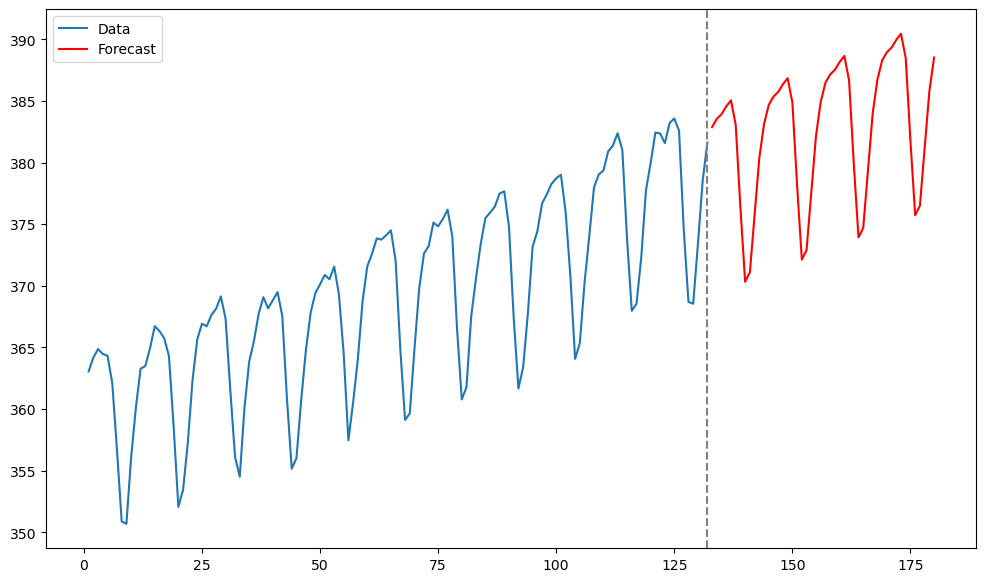

In [18]:
k = 48
n = len(y)
tme = range(1, n+1)
tme_future = range(n+1, n+k+1)
fcast = m1_co2.get_prediction(start = n, end = n+k-1).predicted_mean
plt.figure(figsize = (12, 7))
plt.plot(tme, y, label = 'Data')
plt.plot(tme_future, fcast, label = 'Forecast', color = 'red')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

### Retail Alcohol Sales Data

Let us now consider the following data from FRED. 

  observation_date  MRTSSM4453USN
0       1992-01-01           1509
1       1992-02-01           1541
2       1992-03-01           1597
3       1992-04-01           1675
4       1992-05-01           1822


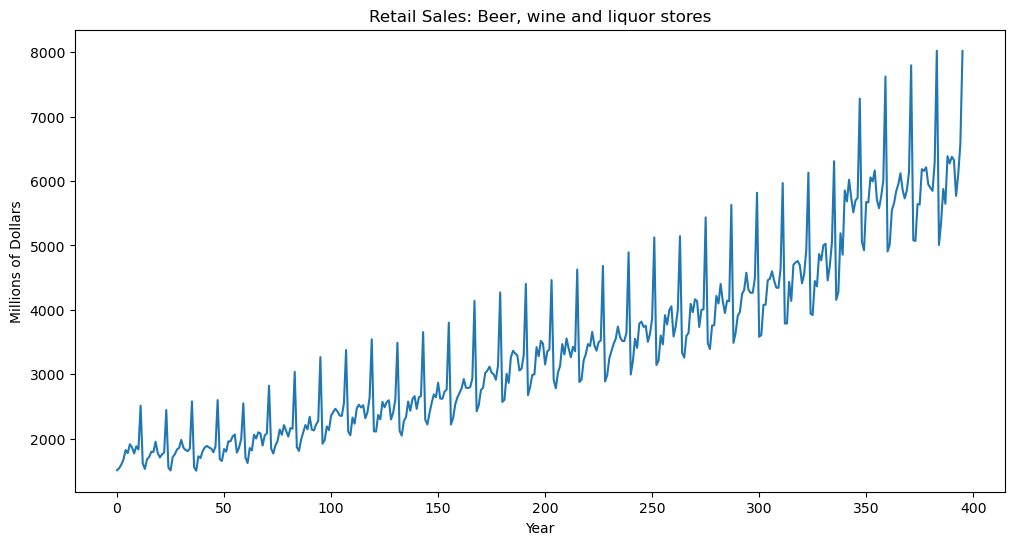

In [19]:
#The following is FRED data on retail sales (in millions of dollars) for beer, wine and liquor stores (https://fred.stlouisfed.org/series/MRTSSM4453USN)
beersales = pd.read_csv('MRTSSM4453USN_March2025.csv')
print(beersales.head())
y = beersales['MRTSSM4453USN']
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.xlabel('Year')
plt.ylabel('Millions of Dollars')
plt.title('Retail Sales: Beer, wine and liquor stores')
plt.show()

In order to fit a stationary model, let us first preprocess by differencing. The seasonal differences are calculated and plotted below. 

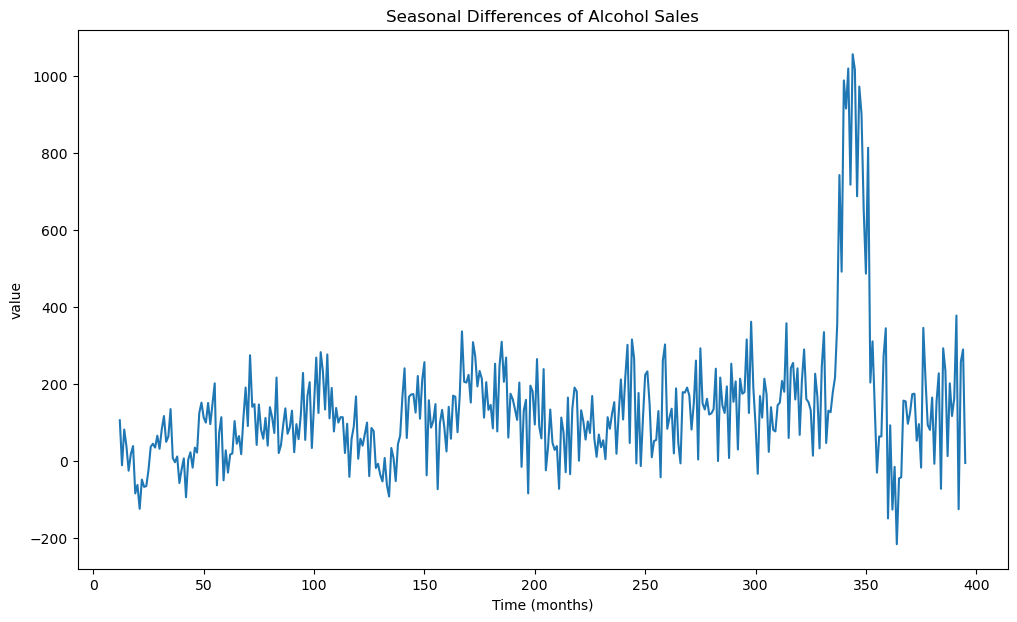

In [20]:
#Seasonal differencing: y_t - y_{t-12}
ydiff12 = y.diff(periods = 12)
plt.figure(figsize = (12, 7))
plt.plot(ydiff12)
plt.xlabel('Time (months)')
plt.ylabel('value')
plt.title('Seasonal Differences of Alcohol Sales')
plt.show()


Certain increasing/decreasing trends are visible in the above data. We do one more differencing below. 

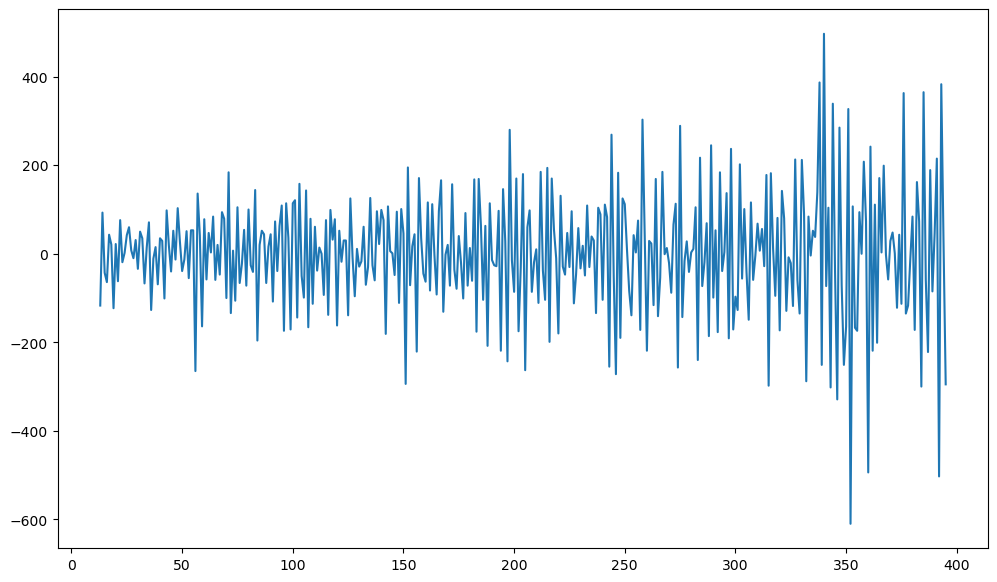

In [21]:
#We now take one more differencing; this time regular differencing
y2d = ydiff12.diff()
plt.figure(figsize = (12, 7))
plt.plot(y2d)
plt.show()

Now let us compute the ACF and PACF. 

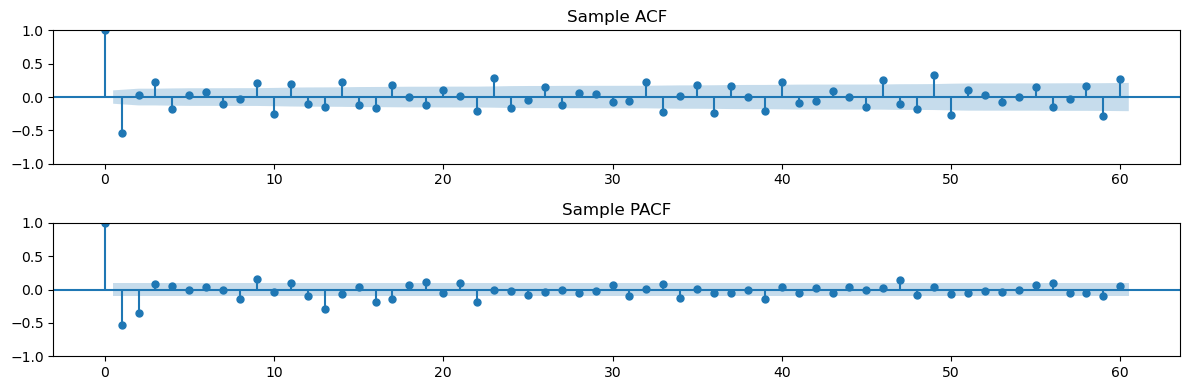

In [22]:
L = 60
# Plot sample ACF/PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4))
plot_acf(y2d.dropna(), lags=L, ax=ax1, title='Sample ACF')
plot_pacf(y2d.dropna(), lags=L, ax=ax2, title='Sample PACF')
plt.tight_layout()
plt.show()

It appears a little hard to determine the orders for an appropriate SARIMA model directly from the above ACF and PACF plot. Below we use a brute force approach where we enumerate a whole bunch of $ARIMA(p, d, q) \times (P, D, Q)_{12}$ models, and then pick the best model via the AIC and BIC criteria. 

In [23]:
dt = y
pmax, dmax, qmax = 2, 1, 2
Pmax, D, Qmax = 2, 1, 2
seasonal_period = 12

results = []

for p in range(pmax + 1):
    for d in range(dmax + 1):
        for q in range(qmax + 1):
            for P in range(Pmax + 1):
                for Q in range(Qmax + 1):
                    try:
                        model = ARIMA(dt, 
                                      order=(p, d, q), 
                                      seasonal_order=(P, D, Q, seasonal_period)).fit()
                        results.append({
                            'p': p, 'd': d, 'q': q,
                            'P': P, 'D': D, 'Q': Q,
                            'AIC': model.aic,
                            'BIC': model.bic
                        })
                    except Exception as e:
                        print(f"ARIMA({p},{d},{q})x({P},{D},{Q}) failed: {e}")
                        continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find best models
best_aic_idx = results_df['AIC'].idxmin()
best_bic_idx = results_df['BIC'].idxmin()

best_aic_model = results_df.loc[best_aic_idx]
best_bic_model = results_df.loc[best_bic_idx]

# Display results
print("Best model by AIC:")
print(best_aic_model)

print("\nBest model by BIC:")
print(best_bic_model)

ARIMA(0,0,1)x(2,1,2) failed: LU decomposition error.


/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

Best model by AIC:
p         2.000000
d         1.000000
q         1.000000
P         2.000000
D         1.000000
Q         2.000000
AIC    4610.329092
BIC    4641.913372
Name: 151, dtype: float64

Best model by BIC:
p         2.000000
d         1.000000
q         0.000000
P         2.000000
D         1.000000
Q         2.000000
AIC    4610.745280
BIC    4638.381525
Name: 142, dtype: float64


/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Of the considered models, the best AIC model is $ARIMA(2, 1, 1) \times (2, 1, 2)_{12}$ and the best BIC model is $ARIMA(2, 1, 0) \times (2, 1, 2)_{12}$. We fit these models below. Observe that there seem to be convergence issues for quite a few models. Fitting these models is not easy and the process involves nonlinear optimization for calculating the MLEs. 

In [24]:
m1 = ARIMA(y, order = (2, 1, 1), seasonal_order = (2, 1, 2, 12)).fit()
print(m1.summary())

                                       SARIMAX Results                                       
Dep. Variable:                         MRTSSM4453USN   No. Observations:                  396
Model:             ARIMA(2, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -2297.165
Date:                               Sat, 19 Apr 2025   AIC                           4610.329
Time:                                       01:07:26   BIC                           4641.913
Sample:                                            0   HQIC                          4622.858
                                               - 396                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7865      0.134     -5.852      0.000      -1.050      -0.523
ar.L2      

In [25]:
m2 = ARIMA(y, order = (2, 1, 0), seasonal_order = (2, 1, 2, 12)).fit()
print(m2.summary())

                                       SARIMAX Results                                       
Dep. Variable:                         MRTSSM4453USN   No. Observations:                  396
Model:             ARIMA(2, 1, 0)x(2, 1, [1, 2], 12)   Log Likelihood               -2298.373
Date:                               Sat, 19 Apr 2025   AIC                           4610.745
Time:                                       01:07:31   BIC                           4638.382
Sample:                                            0   HQIC                          4621.708
                                               - 396                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7378      0.041    -17.980      0.000      -0.818      -0.657
ar.L2      

/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Below we obtain predictions using both the models.

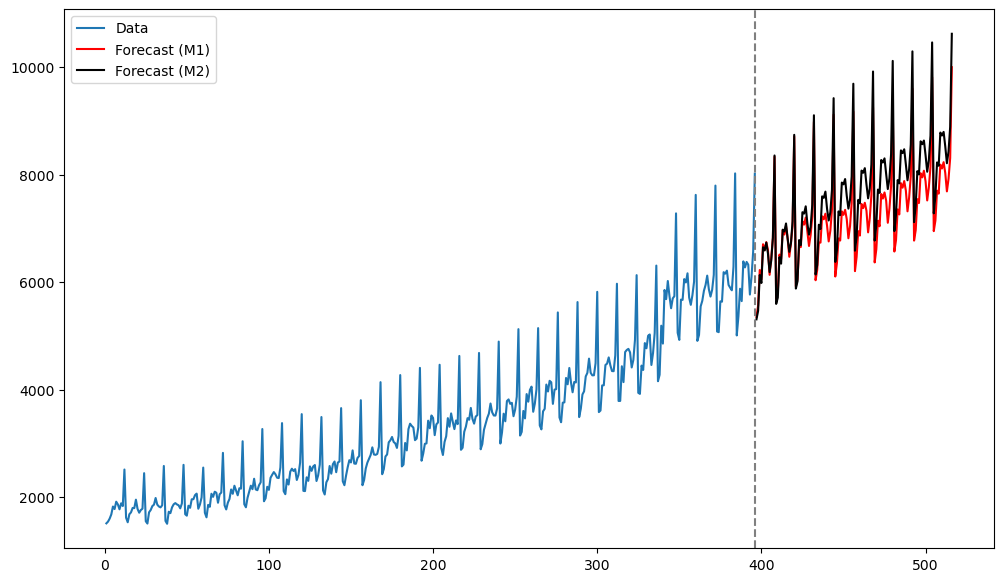

In [26]:
k = 120
n = len(y)
tme = range(1, n+1)
tme_future = range(n+1, n+k+1)
fcast1 = m1.get_prediction(start = n, end = n+k-1).predicted_mean
fcast2 = m2.get_prediction(start = n, end = n+k-1).predicted_mean
plt.figure(figsize = (12, 7))
plt.plot(tme, y, label = 'Data')
plt.plot(tme_future, fcast1, label = 'Forecast (M1)', color = 'red')
plt.plot(tme_future, fcast2, label = 'Forecast (M2)', color = 'black')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

The predictions by both models seems reasonable. At the initial few future time points, the predictions are also quite close to each other. 

## MA(1) Parameter Estimation

Estimating the parameters of ARMA (as well as ARIMA, SARIMA models) is much harder
than parameter estimation in AR models which was handled by standard regression (ordinary
least squares). We will not study this topic (and simply rely on the ARIMA function for fitting
these models to data). But we will perform estimation for MA(1) as shown below. 

To compute estimates of $\mu$ and $\theta$, we can minimize the sum of squares quantity $S(\mu, \theta)$ given by 
\begin{align*}
  S(\mu, \theta) &= \left(y_1 - \frac{\mu}{1 + \theta} \right)^2 +
  \left(y_2 - \frac{\mu}{1 + \theta} - \theta y_1 \right)^2 +
  \left(y_3 - \frac{\mu}{1 + \theta} - \theta y_2 + \theta^2 y_1
  \right)^2 + \dots + \\ &\left(y_n - \frac{\mu}{1 + \theta} - \theta
    y_{n-1} + \theta^2 y_{n-2} - \dots + (-1)^{n-1} \theta^{n-1} y_1
                           \right)^2. 
\end{align*}
The function S_func below computes this function $S(\mu, \theta)$. 

In [27]:
from scipy.optimize import minimize #this is the function that we shall use to minimize S(\mu, \theta)$

def compute_s(y, theta):
    n = len(y)
    s = np.zeros(n)
    s[0] = y[0]
    for t in range(1, n):
        s[t] = y[t] - theta * s[t-1]
    return s

def S_func(params, y): #this is the function S(\mu, \theta)
    mu, theta = params
    if 1 + theta == 0:
        return np.inf  
    s = compute_s(y, theta)
    target = mu / (1 + theta)
    return np.sum((s - target)**2)


Let us simulate a dataset from the MA(1) model with $\mu = 0$ and $\theta = -0.7$ to evaluate the performance of our estimation strategy. 

In [28]:
arma_process = ArmaProcess([1], [1, -0.7])
dt = arma_process.generate_sample(nsample=400)

The output from using the ARIMA function is given below. 

In [29]:
ma_mod = ARIMA(dt, order = (0, 0, 1)).fit()
print(ma_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  400
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -540.927
Date:                Sat, 19 Apr 2025   AIC                           1087.853
Time:                        01:12:36   BIC                           1099.828
Sample:                             0   HQIC                          1092.595
                                - 400                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.012     -0.226      0.821      -0.026       0.021
ma.L1         -0.7464      0.035    -21.193      0.000      -0.815      -0.677
sigma2         0.8735      0.069     12.702      0.0

Now we obtain $\hat{\mu}$ and $\hat{\theta}$ by minimizing $S(\mu, \theta)$ and we can compare our estimates with those reported by the above ARIMA function. We shall use the inbuilt optimization function \texttt{minimize}. It requires initial values which we take to be $\theta = 0$ and $\mu$ to be the mean of the data. 

In [30]:
# Initial guess: [mu_init, theta_init]
mu_init = np.mean(dt)
theta_init = 0
init_params = [mu_init, theta_init]

# Perform the optimization
result = minimize(S_func, init_params, args=(dt,))
print(result)
mu_hat, theta_hat = result.x
alphaest = result.x

print("Estimated mu:", mu_hat)
print("Estimated theta:", theta_hat)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 349.95037593379897
        x: [-3.971e-03 -7.474e-01]
      nit: 12
      jac: [ 3.815e-06  0.000e+00]
 hess_inv: [[ 7.978e-05 -1.413e-06]
            [-1.413e-06  6.066e-04]]
     nfev: 60
     njev: 20
Estimated mu: -0.00397079554935901
Estimated theta: -0.747415904826925


The estimates are quite close to those obtained by ARIMA.

To obtain the standard errors for uncertainty quantification, we shall use the formula given at the end of the notes for Lecture 23. This formula involves calculating the Hessian matrix of $S(\mu, \theta)$ at the point estimates $\hat{\mu}$ and $\hat{\theta}$. We shall use the python library numdifftools for numerically evaluating the Hessian of $S(\mu, \theta)$. 

In [31]:
import numdifftools as nd #this library has functions to calculate first and second derivatives 

H = nd.Hessian(lambda alpha: S_func(alpha, dt), step = 1e-6)(alphaest)

sighat = np.sqrt(S_func(alphaest, dt) / (n - 2))
covmat = (sighat ** 2) * np.linalg.inv(0.5 * H)
stderrs = np.sqrt(np.diag(covmat))

# ---- Output ----
print("Estimated mu:", alphaest[0])
print("Estimated theta:", alphaest[1])
print("Estimated sigma:", sighat)
print("Covariance matrix:\n", covmat)
print("Standard errors:", stderrs)

Estimated mu: -0.00397079554935901
Estimated theta: -0.747415904826925
Estimated sigma: 0.9424430612455296
Covariance matrix:
 [[ 1.41671210e-04 -2.63105421e-06]
 [-2.63105421e-06  1.07831062e-03]]
Standard errors: [0.01190257 0.03283764]


The obtained standard errors are also close to those obtained from ARIMA. 

### One more example

Here is one more example where we can check that our estimates and their standard errors for parameters in MA(1) are close to those obtained from the ARIMA function. 

In [32]:
beersales = pd.read_csv('MRTSSM4453USN_March2025.csv')
y = beersales['MRTSSM4453USN']
ydiff12 = y.diff(periods = 12)
y2d = ydiff12.diff()
dt = y2d.dropna().to_numpy()

Below we fit MA(1) via the ARIMA function. 

In [33]:
ma_mod = ARIMA(dt, order = (0, 0, 1)).fit()
print(ma_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  383
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -2358.779
Date:                Sat, 19 Apr 2025   AIC                           4723.558
Time:                        01:20:09   BIC                           4735.402
Sample:                             0   HQIC                          4728.256
                                - 383                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1714      2.575      0.067      0.947      -4.876       5.219
ma.L1         -0.5697      0.028    -20.263      0.000      -0.625      -0.515
sigma2      1.308e+04    652.547     20.037      0.0

Next we fit MA(1) using our method. 

In [34]:
# Initial guess: [mu_init, theta_init]
mu_init = np.mean(dt)
theta_init = 0
init_params = [mu_init, theta_init]

# Perform the optimization
result = minimize(S_func, init_params, args=(dt,))
print(result)
mu_hat, theta_hat = result.x
alphaest = result.x

print("Estimated mu:", mu_hat)
print("Estimated theta:", theta_hat)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5011626.773814039
        x: [ 3.935e-02 -5.698e-01]
      nit: 14
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 6.139e-06 -3.174e-07]
            [-3.174e-07  7.938e-08]]
     nfev: 72
     njev: 24
Estimated mu: 0.03934764631035018
Estimated theta: -0.569755702273577


The estimated $\theta$ is quite close to that given by ARIMA. The estimate of $\mu$ seems slightly off from that given by ARIMA. Standard errors are computed below.

In [35]:
import numdifftools as nd #this library has functions to calculate first and second derivatives 

H = nd.Hessian(lambda alpha: S_func(alpha, dt), step = 1e-6)(alphaest)

sighat = np.sqrt(S_func(alphaest, dt) / (n - 2))
covmat = (sighat ** 2) * np.linalg.inv(0.5 * H)
stderrs = np.sqrt(np.diag(covmat))

# ---- Output ----
print("Estimated mu:", alphaest[0])
print("Estimated theta:", alphaest[1])
print("Estimated sigma:", sighat)
print("Covariance matrix:\n", covmat)
print("Standard errors:", stderrs)

Estimated mu: 0.03934764631035018
Estimated theta: -0.569755702273577
Estimated sigma: 112.78237853564474
Covariance matrix:
 [[ 6.07038956e+00 -5.25557790e-04]
 [-5.25557790e-04  1.18250503e-03]]
Standard errors: [2.46381606 0.03438757]


These standard errors seem close to those given by ARIMA. 